# Import Your Files

In [17]:
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt

# this is the directory containing fits files

fits_dir = "C:\\Users\\....\FILE"

files = os.listdir(fits_dir)
os.listdir(fits_dir)

['fluor.fits',
 'fluor_1.fits',
 'fluor_2.fits',
 'fluor_3.fits',
 'fluor_4.fits',
 'fluor_5.fits',
 'fluor_6.fits',
 'fluor_7.fits',
 'fluor_8.fits',
 'lum.fits',
 'lum_1.fits',
 'lum_2.fits',
 'lum_3.fits',
 'lum_4.fits',
 'lum_5.fits',
 'lum_6.fits',
 'lum_7.fits',
 'lum_8.fits']

In [18]:
os.chdir(fits_dir)

flour_files = ['fluor.fits', 'fluor_1.fits', 'fluor_2.fits', 'fluor_3.fits', 'fluor_4.fits', 'fluor_5.fits',
 'fluor_6.fits', 'fluor_7.fits', 'fluor_8.fits']

lum_files = ['lum.fits', 'lum_1.fits', 'lum_2.fits', 'lum_3.fits', 'lum_4.fits', 'lum_5.fits', 'lum_6.fits',
 'lum_7.fits', 'lum_8.fits']

f_stack = []
l_stack = []


# this for loop reads flourescence and luminescence files and store them in seperate lists.
for i in range(9):

    img = fits.open(flour_files[i])
    
    # average last ten frames
    img = np.mean(img[0].data[10:,:,:], axis=0)
    f_stack.append(img)
    
    img = fits.open(lum_files[i])
    l_stack.append(img[0].data[0,:,:])
    

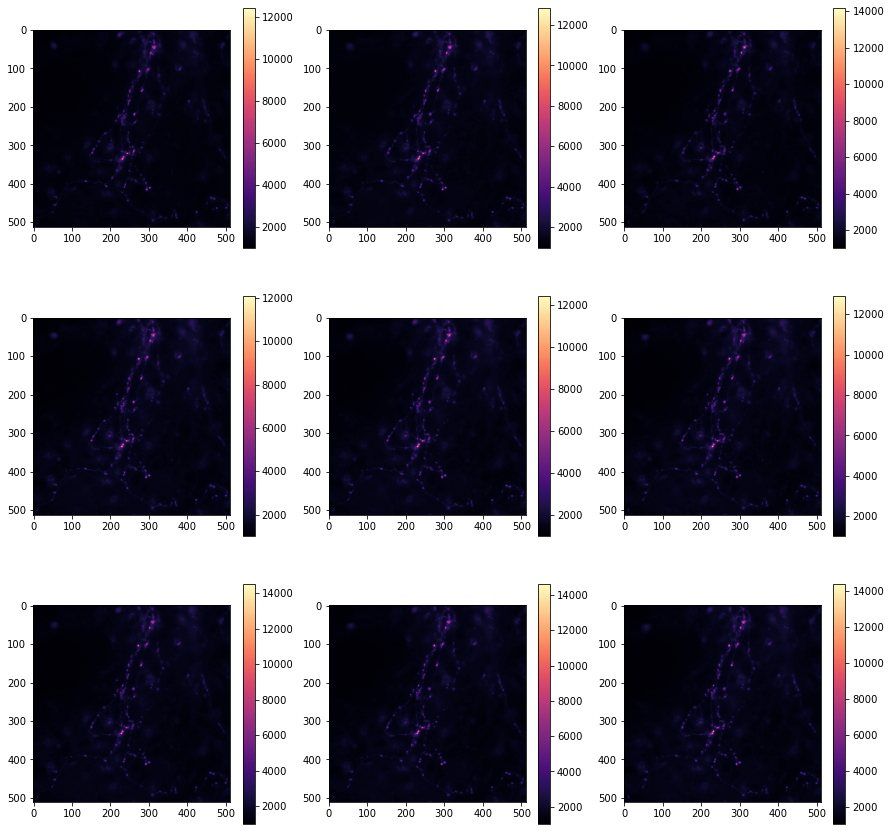

In [19]:
plt.figure(figsize=(15,15))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(f_stack[i], cmap="magma")
    plt.colorbar()

# Kmeans clustering of luminescence images for finding background

In [20]:
from skimage.measure import block_reduce
from sklearn.cluster import KMeans

def cluster_lum(img, n = 4):
    
    # downsample images into 512/n x 512/n images through using median for n x n squares
    l_mean_down = block_reduce(img, (n,n), np.median)
    
    # cluster pixels into 2 clusters to find background
    pixel_values = l_mean_down.reshape(-1,1)
    kmeans = KMeans(n_clusters = 2, random_state = 42).fit(pixel_values)

    clusters = kmeans.labels_
    clusters = clusters.reshape((int(512/n),int(512/n)))
    
    bck = np.argmax(np.unique(clusters, return_counts=True)[1])
    clusters = np.where(clusters == bck, 0, 1)
    
    return clusters, l_mean_down
    

# Localizing cell body by finding the n by n square with the highest luminescence value

In [21]:
# Change d to adjust the size of localizer

def cell_body(img, d = 32, n = 4):

    img = block_reduce(img, (n,n), np.median)

    coordinates = []
    intensities = []

    for i in range(0, img.shape[0] - d):
        for j in range(0, img.shape[1] - d):

            intensity = np.mean(img[i : i + d, j : j + d])
            intensities.append(intensity)
            coordinates.append([i,j])


    cc = coordinates[np.argmax(intensities)]

    mask = np.zeros(img.shape)

    mask[cc[0]:cc[0]+d, cc[1]:cc[1]+d] = 1
    
    return mask

# Key Step: Visualize and Adjust Cell Body Masking If Needed

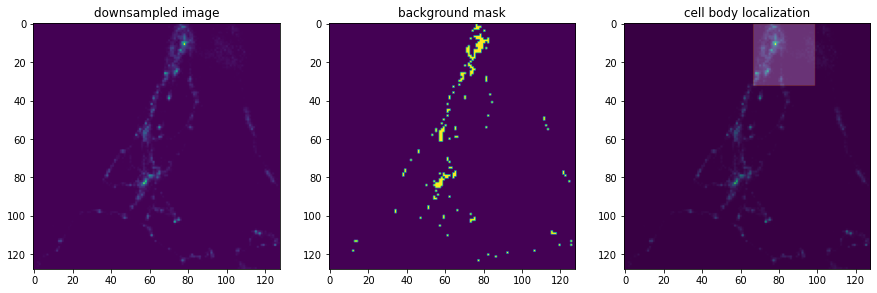

Are you satisfied with cell body mask Y/N: Y


In [22]:
from IPython.display import clear_output

# change d in this box to alter the cell body mask size 
mask, lum_down = cluster_lum(l_stack[2])
cb_mask = cell_body(l_stack[2], d = 32)

satisfied = "N"

while satisfied != "Y":
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title("downsampled image")
    plt.imshow(lum_down)

    plt.subplot(1,3,2)
    plt.title("background mask")
    plt.imshow(mask)

    plt.subplot(1,3,3)
    plt.title("cell body localization")
    plt.imshow(lum_down)
    plt.imshow(cb_mask, alpha = 0.2, cmap = "hot")

    plt.show()

    satisfied = input("Are you satisfied with cell body mask Y/N: ")
    if(satisfied != "Y"):
        y = input("please type y coordinate: ")
        y = int(y)
        x = input("please type x coordinate: ")
        x = int(x)
        size = input("please type size of the box: ")
        size = int(size)
        clear_output()
        
        cb_mask = np.zeros(lum_down.shape)
        cb_mask[y:y+size, x:x+size] = 1

# change d in the next box to alter the cell body mask size in the analysis, after reviewing the image in this box

# Define Gain Level ( for FL 60, adjusted = True)

In [23]:
# With this function linear changes in the imaging due to hardware alteration can be defined. 
# for the images obtained with Flourescent Gain of 60, Adjusted = True

lf_list = []
lum_list = []
fluor_list = []
n = 4
#d = 10
adjusted = True

for i in range(9):
    #cb_mask = cell_body(l_stack[i], d)
    c, l = cluster_lum(l_stack[i])
    bck = np.mean(l[c == 0])
    l = l - bck
    l = np.where(l > 0, l , 0)
    
    
    f = block_reduce(f_stack[i], (n,n), np.median)
    bck = np.mean(f[c == 0])
    # adjusted = True : F for Flourescent Gain 60 of Andor Software
    if adjusted == True:
        f = (f-bck)/2.9201091
    else:
        f = f - bck
    f = np.where(f > 0 , f, 0)
    
    c = np.where(cb_mask == 1, 0, c)
    
    r = np.mean(l[c == 1])/np.mean(f[c == 1])

    print(r, np.mean(l[c == 1]), np.mean(f[c == 1]))
    lf_list.append(r)
    lum_list.append(np.mean(l[c == 1]))
    fluor_list.append(np.mean(f[c == 1]))

3.014317166316713 1257.451493651979 417.1596498547954
2.9189998574460643 1417.9692458132115 485.77229018909327
2.818636071013955 1667.569003588379 591.6226719501608
2.936050797507335 1391.491969225894 473.9332066077504
2.4394169382518887 1061.4310370172389 435.11669545833
2.517852768842353 1267.1934398128058 503.2833752211136
2.848631697356241 1438.2384184148668 504.8874586875052
2.900972100671915 1541.271080625406 531.2946926543765
2.96146201195787 1546.1098441936365 522.0765412322404


# Results

In [24]:
#L/F Total Synaptic ATP levels
lf_list

[3.014317166316713,
 2.9189998574460643,
 2.818636071013955,
 2.936050797507335,
 2.4394169382518887,
 2.517852768842353,
 2.848631697356241,
 2.900972100671915,
 2.96146201195787]

Text(0, 0.5, 'intensity')

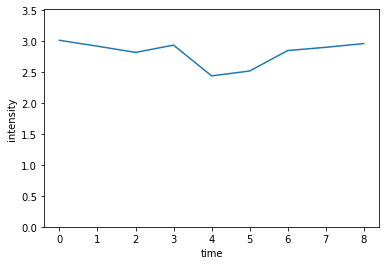

In [25]:
plt.plot(lf_list)

plt.ylim(0,np.max(lf_list)+0.5)
plt.xlabel("time")
plt.ylabel("intensity")

# save output file to a MS Excel file 

In [26]:
import pandas as pd 

output_df = pd.DataFrame([lf_list, lum_list, fluor_list]).transpose()
output_df.columns = ["L/F", "L", "F"]

output_df

# file's name will be the same as its folder name
file_name = fits_dir.split("\\")[-1] + ".xlsx"

# Files will be saved in this location
destination_folder = "C:\\......\\Excel files"

file_location = destination_folder + "\\" + file_name

output_df.to_excel(file_location)